<a href="https://colab.research.google.com/github/alanbseo/FlickrWorkshopUFZ/blob/master/UFZ_1_PretrainedCNN_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this session, we are using a simple photo tagging without additional training. The model we are going to use is one of the best Convolutional Neural Network (CNN) model. It is generally well trained about intermediate level features like color, texture, shape. However, it does not know well about ecosystem and ecological objects.   

Note: don't forget to change the runtime type from None to GPU!

In [0]:
# First some preparation scripts 
# I'll skip this part today, but please let me know if you want to get to know about those 
 
import numpy as np
import os

import cv2
import numpy as np
import pandas as pd
import skimage.io # scikit image 

### The below is to avoid certificat error 
# source: https://stackoverflow.com/questions/27835619/urllib-and-ssl-certificate-verify-failed-error
import requests

requests.packages.urllib3.disable_warnings()

import ssl

try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    # Legacy Python that doesn't verify HTTPS certificates by default
    pass
else:
    # Handle target environment that doesn't support HTTPS verification
    ssl._create_default_https_context = _create_unverified_https_context


In [0]:
# Import Keras and image manipulating libraries 

from keras.applications import inception_resnet_v2
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array

from keras import backend as k


# # Typical input image sizes to a Convolutional Neural Network trained on ImageNet are 224×224, 227×227, 256×256, and 299×299; however, you may see other dimensions as well.
# # VGG16, VGG19, and ResNet all accept 224×224 input images while Inception V3 and Xception require 299×299 pixel inputs, as demonstrated by the following code block:
# # Nasnet large 331x331. If you train your own classes (i.e. the final Fully Connected/Dense layer), you can modify the img size 
img_width, img_height = 299, 299

# to decode predictions
from keras.applications.imagenet_utils import decode_predictions

 

In [0]:
# import urllib
# import keras 
# image = urllib.request.urlopen(image_url)
# content = image.read()
# keras.preprocessing.image.load_img(content, target_size=(img_height, img_width))



We use a model called `inceptionv4resnetv2`. It is an excellent CNN model extensively used in computer vision. In standardides evaluation set-up, it is said it has 80% Top-1 Accuracy and 95% Top-5 Accuracy (i.e.  if the target label is one of your top 5 predictions).

In [0]:


#Load the inception_v4_resnet_v2
# https://ai.googleblog.com/2016/08/improving-inception-and-image.html
model_pretrained = inception_resnet_v2.InceptionResNetV2(weights='imagenet')


In [0]:
# Load a image from Internet
image_url = "http://www.sportstimemagazine.com/wp-content/uploads/2017/06/Boost_18_1112_29-752x440.jpg"
image_url = "https://images.mentalfloss.com/sites/default/files/styles/mf_image_16x9/public/516438-istock-637689912.jpg"
# image_url = "https://boygeniusreport.files.wordpress.com/2016/11/puppy-dog.jpg?quality=98&strip=all"

# original = skimage.io.imread(image_url)
# skimage.io.imshow(original)

# from skimage.transform import resize
# image_input = resize(original, (img_height, img_width))

# skimage.io.imshow(image_input)

# # load an image in PIL format
# # original = load_img(filename, target_size=(299, 299))
# original = load_img(image_url, target_size=(331, 331)) @todo did not work scikit + PIL.. need to fix
 



PIL image size (299, 299)


Some necessary image pre-processing. Basically we read an image and convert the image to numpy format and put it into a batch array; in thie example we have a single image but many will be if batch processing.

In [0]:

from PIL import Image
 
from urllib.request import urlopen
img =Image.open(urlopen(image_url))
image_input =img.resize((img_height,img_width),Image.ANTIALIAS)
# image_input.save('url.jpg','jpeg') # to save the image locally 

print('PIL image size', image_input.size)
 




# convert the PIL image to a numpy array
# IN PIL - image is in (width, height, channel)
# In Numpy - image is in (height, width, channel)
numpy_image = img_to_array(image_input)
# plt.imshow(np.uint8(numpy_image))
# plt.show()
print('numpy array size',numpy_image.shape)

# Convert the image / images into batch format
# expand_dims will add an extra dimension to the data at a particular axis
# We want the input matrix to the network to be of the form (batchsize, height, width, channels)
# Thus we add the extra dimension to the axis 0.
image_batch = np.expand_dims(numpy_image, axis=0)
print('image batch size', image_batch.shape)
# plt.imshow(np.uint8(image_batch[0]))





 


numpy array size (299, 299, 3)
image batch size (1, 299, 299, 3)


Before looking into the network or anything, first we are doing something interesting and consider the inception model as a magic black-box. 

In [0]:
# get the predicted probabilities for each class
predictions = model_pretrained.predict(processed_image)
# print predictions

# print(predictions)

# convert the probabilities to class labels
# We will get top 5 predictions which is the default
predicted_tags = decode_predictions(predictions, top=5)[0]

# print predictions

print('Predicted:', predicted_tags )






Predicted: [('n02099601', 'golden_retriever', 0.9275075), ('n02099712', 'Labrador_retriever', 0.0100292), ('n02102318', 'cocker_spaniel', 0.0013605809), ('n02101556', 'clumber', 0.001314079), ('n02093991', 'Irish_terrier', 0.0011871092)]


In [0]:
# This is the dominant entry in the prediction vector
dominant_feature_idx = np.argmax(predictions[0])
dominant_output = model_pretrained.output[:, dominant_feature_idx]

 
# The is the output feature map of the `conv_7b_ac` layer,
# the last convolutional layer in InceptionResnetV2
last_conv_layer = model_pretrained.get_layer('conv_7b_ac')

# This is the gradient of the dominant class with regard to
# the output feature map of `conv_7b_ac`
grads = k.gradients(dominant_output, last_conv_layer.output)[0]

# This is a vector of shape (1536,), where each entry
# is the mean intensity of the gradient over a specific feature map channel
pooled_grads = k.mean(grads, axis=(0, 1, 2))

# This function allows us to access the values of the quantities we just defined:
# `pooled_grads` and the output feature map of `conv_7b_ac`,
# given a sample image
iterate = k.function([model_pretrained.input], [pooled_grads, last_conv_layer.output[0]])

# These are the values of these two quantities, as Numpy arrays,
# given our sample image of two elephants
pooled_grads_value, conv_layer_output_value = iterate([processed_image])



In [0]:
grad_dim = grads.shape[3]
print(grad_dim)

1536


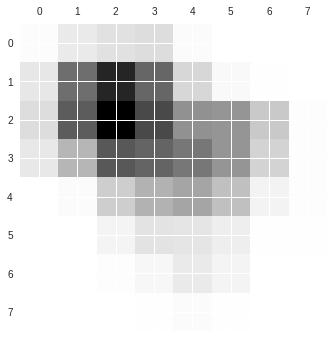

In [0]:
# We multiply each channel in the feature map array
# by "how important this channel is" with regard to the elephant class
for i in range(grad_dim):
  conv_layer_output_value[:, :, i] *= pooled_grads_value[i]

# The channel-wise mean of the resulting feature map
# is our heatmap of class activation
heatmap = np.mean(conv_layer_output_value, axis=-1)


# For visualization purpose, we will also normalize the heatmap between 0 and 1:

heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)
plt.matshow(heatmap)
plt.show()

In [0]:



# We use cv2 to load the original image
img = cv2.imread(fname)

# We resize the heatmap to have the same size as the original image
heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))

# We convert the heatmap to RGB
heatmap = np.uint8(255 * heatmap)

# We apply the heatmap to the original image
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

# 0.4 here is a heatmap intensity factor
superimposed_img = heatmap * 0.4 + img

# Choose a font
font = cv2.FONT_HERSHEY_COMPLEX

# Draw the text

for x in range(0, num_classes):
  tags = classes[x] + ":" + str((predictions[0][x]*100).round(2)) + "%"
  cv2.putText(superimposed_img,tags,(10, 100 * x + int(img.shape[0]/3)), font, 2,(255,255,255),2) # ,cv2.LINE_AA)


# os.mkdir("Result/Heatmap_" + modelname + "/" + predicted_class)

# Save the image to disk
cv2.imwrite("Result/Heatmap_" + modelname + "/" + predicted_class + "/AttentionMap_" + predicted_class + "_" + filename, superimposed_img)


NameError: ignored


When you are done with the exercise, we recommend continue exploring the python notebook of François Chollet (https://github.com/fchollet/deep-learning-with-python-notebooks), who developed the libaray we use, Keras. He authored a book called `Deep Learning with Python' (https://www.manning.com/books/deep-learning-with-python); the book is the best introduction to the topic as far as I explored.

Recommend going through 

https://nbviewer.jupyter.org/github/fchollet/deep-learning-with-python-notebooks/blob/master/5.1-introduction-to-convnets.ipynb
https://nbviewer.jupyter.org/github/fchollet/deep-learning-with-python-notebooks/blob/master/5.2-using-convnets-with-small-datasets.ipynb